# CICIDS

### **random_forest.ipynb**

The CICIDS2017 dataset is a comprehensive dataset for network intrusion detection, created by the Canadian Institute for Cybersecurity. It includes a diverse set of attack scenarios and normal traffic, making it suitable for training and evaluating intrusion detection systems.

The dataset includes various types of attacks such as Brute Force, Heartbleed, Botnet, DoS (Denial of Service), DDoS (Distributed Denial of Service), Web attacks, and Infiltration of the network from inside.

In [1]:
model_name = "random_forest_(BINARY)"

In [2]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Step 1. Read data and import necessary libraries

In [3]:
import pandas as pd
df_train = pd.read_csv("../data/concatenated/concat.csv")

In [4]:
df_train.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
df_train.shape

(2830743, 79)

In [6]:
# df_train.info()

In [7]:
# df_train.describe()

In [8]:
# Remove leading and trailing whitespaces from column names
df_train.columns = df_train.columns.str.strip()

In [9]:
# df_train.columns

## Step 2. Data Cleaning

### A. Missing values

In [10]:
print(df_train.isna().sum().sum())

1358


In [11]:
df_train.dropna(subset=["Flow Bytes/s"], inplace=True)

In [12]:
print(df_train.isna().sum().sum())

0


### Inf. values

In [13]:
import numpy as np
df_train = df_train.replace([np.inf, -np.inf], np.nan).dropna()

## Step 3. Data Preparation

### A. Normalise numeric features

In [14]:
# Get all numerical columns
numerical_columns = df_train.select_dtypes(include="number").columns

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_train[numerical_columns] = scaler.fit_transform(df_train[numerical_columns])

### B. Apply SMOTE to balance all data

In [16]:
from imblearn.under_sampling import RandomUnderSampler

# Step 1: Undersample majority classes
class_counts = df_train["Label"].value_counts()
undersampling_strategy = {cls: min(10_000, count) for cls, count in class_counts.items()}

rus = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=42)
X_resampled, y_resampled = rus.fit_resample(df_train.drop(columns=["Label"]), df_train["Label"])

# Convert back to DataFrame
df_resampled = X_resampled.copy()
df_resampled["Label"] = y_resampled

### B. Map Labels to binary

In [17]:
# Step 2: Convert multi-class labels to binary labels
df_resampled["Label"] = df_resampled["Label"].apply(lambda x: 0 if x == "BENIGN" else 1)

### C. Data Splitting

In [18]:
from sklearn.model_selection import train_test_split

X = df_resampled.drop(columns="Label")
y = df_resampled["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 4. Model

#### A. Defining the model

In [19]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import numpy as np

In [ ]:
param_dist = {
	"n_estimators": np.arange(250, 350, 25),
	"max_depth": [10, 20, 30],
	"min_samples_split": [2, 4, 6],
	"min_samples_leaf": [1, 2, 3],
	"max_features": ["sqrt", "log2"],
	"bootstrap": [True, False]
}

# Best parameters found:  {
    # 'n_estimators': 325, 
    # 'min_samples_split': 4, 
    # 'min_samples_leaf': 1, 
    # 'max_features': 'sqrt', 
    # 'max_depth': 30, 
    # 'bootstrap': False
# }

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
	rf, param_distributions=param_dist,
	n_iter=200, cv=5,
	n_jobs=-1, verbose=3,
	random_state=42, return_train_score=True)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': array([250, 275, 300, 325])},
                   random_state=42, return_train_score=True, verbose=3)

### B. Training the model

In [22]:
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

param_grid = {
	"n_estimators": [best_params["n_estimators"] - 10, best_params["n_estimators"], best_params["n_estimators"] + 10],
	"max_depth": [best_params["max_depth"] - 5 if best_params["max_depth"] is not None else None, best_params["max_depth"], best_params["max_depth"] + 5 if best_params["max_depth"] is not None else None],
	"min_samples_split": [max(2, best_params["min_samples_split"] - 1), best_params["min_samples_split"], best_params["min_samples_split"] + 1],
	"min_samples_leaf": [max(1, best_params["min_samples_leaf"] - 1), best_params["min_samples_leaf"], best_params["min_samples_leaf"] + 1],
	"max_features": [best_params["max_features"]],
	"bootstrap": [best_params["bootstrap"]],
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# BINARY
# 405 fits ->    42s

Best parameters found:  {'n_estimators': 325, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [25, 30, 35],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 1, 2],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [315, 325, 335]},
             verbose=2)

In [23]:
print("Best parameters found by GridSearchCV: ", grid_search.best_params_)

Best parameters found by GridSearchCV:  {'bootstrap': False, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 325}


### G. Evaluating the model

In [24]:
# Balance the test set
# 1. Undersample the majority classes, and keep the values for the minority classes

SAMPLE_TARGET = 10_000
undersampling_strategy_test_set = {
    0: SAMPLE_TARGET if y_test.value_counts().get(0) > SAMPLE_TARGET else y_test.value_counts().get(0),	# BENIGN
	1: SAMPLE_TARGET if y_test.value_counts().get(1) > SAMPLE_TARGET else y_test.value_counts().get(1),	# Attack
}

rus_test = RandomUnderSampler(random_state=42, sampling_strategy=undersampling_strategy_test_set)
X_test_balanced, y_test_balanced = rus_test.fit_resample(X_test, y_test)


In [25]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_balanced)

In [26]:
print("Accuracy: ", accuracy_score(y_test_balanced, y_pred))
print("F1 Score: ", f1_score(y_test_balanced, y_pred, average="weighted"))

Accuracy:  0.9987463435018805
F1 Score:  0.9987462153028486


In [27]:
print(classification_report(y_test_balanced, y_pred, target_names=["BENIGN", "Attack"]))

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00      1965
      Attack       1.00      1.00      1.00     10000

    accuracy                           1.00     11965
   macro avg       1.00      1.00      1.00     11965
weighted avg       1.00      1.00      1.00     11965



### **Previous results:**

| Metric          | Regular, multi-class | CV, multi-class | CV, binary  | does the binary model perform better than multi-class? |
| --------------- | -------------------- | --------------- | ----------- | ------------------------------------------------------ |
| Accuracy        | 0.95                 | 0.98            | 1.00        | <span style="color:#20ff20;">yes</span>                |
| MA Range        | 0.95 - 0.95          | 0.89 - 0.91     | 1.00 - 1.00 | <span style="color:#20ff20;">yes</span>                |
| WA Range        | 0.95 - 0.95          | 0.98 - 0.98     | 1.00 - 1.00 | <span style="color:#20ff20;">yes</span>                |
| Precision range | 0.66 - 1.00          | 0.36 - 1.00     | 1.00 - 1.00 | <span style="color:#20ff20;">yes</span>                |
| Recall range    | 0.57 - 1.00          | 0.57 - 1.00     | 1.00 - 1.00 | <span style="color:#20ff20;">yes</span>                |
| F1 range        | 0.63 - 1.00          | 0.44 - 1.00     | 1.00 - 1.00 | <span style="color:#20ff20;">yes</span>                |

In [28]:
# Get feature importances
feature_importances = best_rf.feature_importances_
features = X.columns

feature_importances_df = pd.DataFrame({
    "Feature": features,
	"Importance": feature_importances
})

feature_importances_df = feature_importances_df.sort_values(by="Importance", ascending=False)
feature_importances_df["Importance"] = round((feature_importances_df["Importance"] * 100), 4)
feature_importances_df

,Feature,Importance
66,Init_Win_bytes_forward,12.1050
0,Destination Port,9.5223
11,Bwd Packet Length Min,7.4910
38,Min Packet Length,7.4210
67,Init_Win_bytes_backward,6.2497
...,...,...
56,Fwd Avg Bytes/Bulk,0.0000
57,Fwd Avg Packets/Bulk,0.0000
58,Fwd Avg Bulk Rate,0.0000
59,Bwd Avg Bytes/Bulk,0.0000


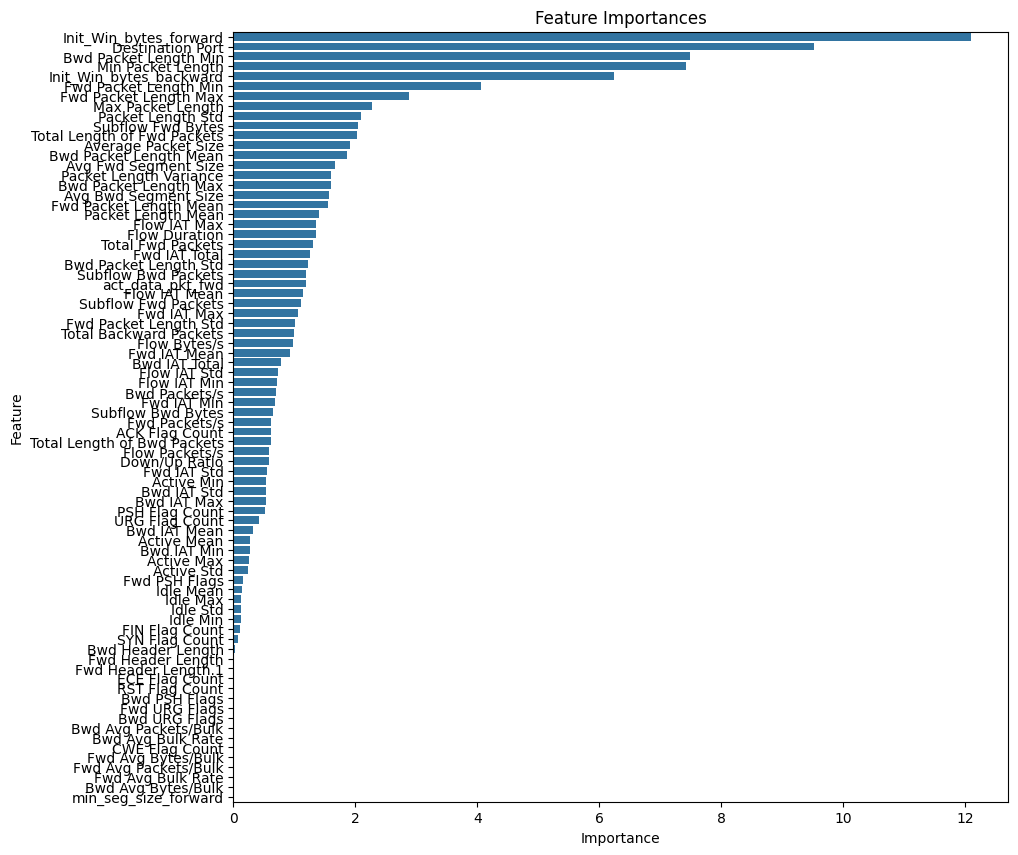

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.barplot(x="Importance", y="Feature", data=feature_importances_df)
plt.title("Feature Importances")
plt.show()